In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
import warnings

# Menonaktifkan semua warning
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('ecoli.csv')
df

,mcg,gvh,lip,chg,aac,alm1,alm2,label
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
...,...,...,...,...,...,...,...,...
331,0.74,0.56,0.48,0.5,0.47,0.68,0.30,pp
332,0.71,0.57,0.48,0.5,0.48,0.35,0.32,pp
333,0.61,0.60,0.48,0.5,0.44,0.39,0.38,pp
334,0.59,0.61,0.48,0.5,0.42,0.42,0.37,pp


In [ ]:
df.dtypes

mcg      float64
gvh      float64
lip      float64
chg      float64
aac      float64
alm1     float64
alm2     float64
label     object
dtype: object

In [ ]:
df['label'].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: label, dtype: int64

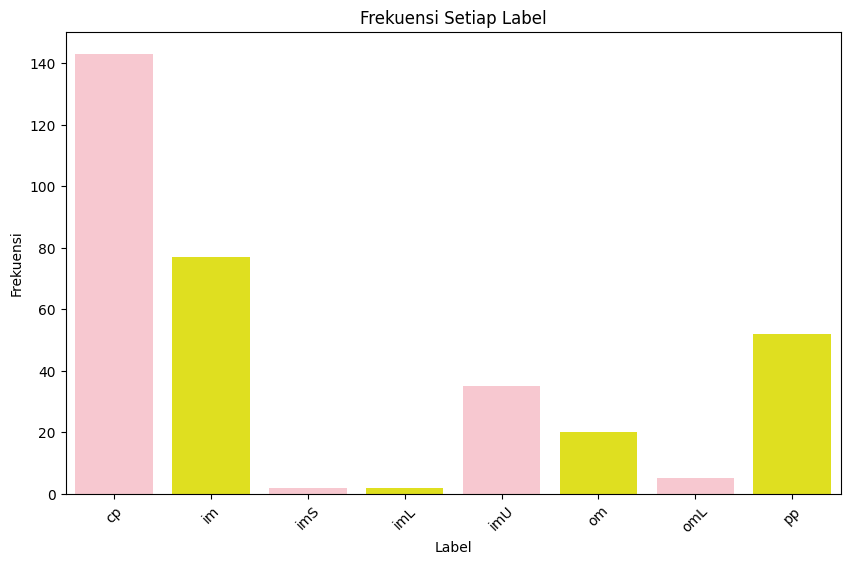

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', palette=['pink', 'yellow'])
plt.title('Frekuensi Setiap Label')
plt.xlabel('Label')
plt.ylabel('Frekuensi')
plt.xticks(rotation=45)
plt.show()


In [ ]:
fitur = ['mcg','gvh','lip','chg','aac','alm1','alm2']
X = df[fitur]
y = df.label

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Oversampling dengan RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Pembagian Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


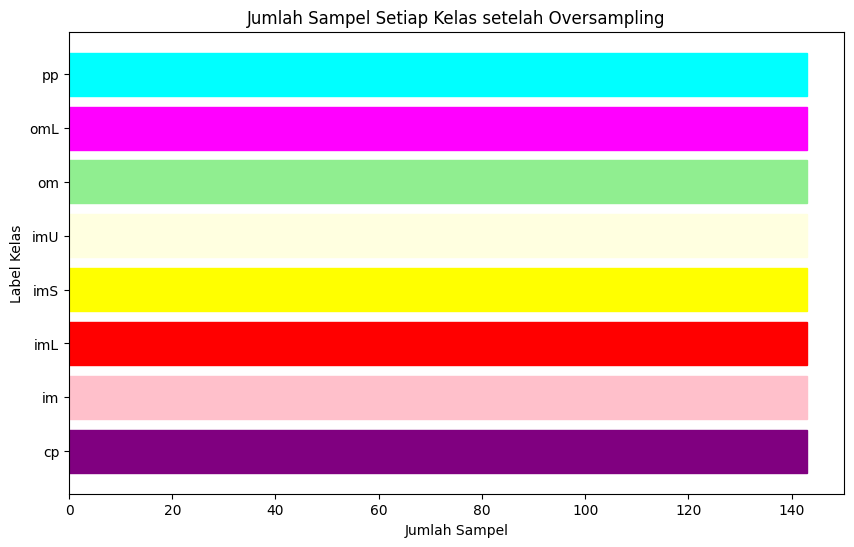

In [ ]:
# Membuat grafik batang horizontal
plt.figure(figsize=(10, 6))
bars = plt.barh(unique_classes, class_counts)

# Memberi warna berbeda pada setiap batang
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.title('Jumlah Sampel Setiap Kelas setelah Oversampling')
plt.ylabel('Label Kelas')
plt.xlabel('Jumlah Sampel')
plt.yticks(unique_classes)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Base model
clf1 = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=10)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(probability=True, random_state=42)
clf4 = GaussianNB()
clf5 = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.0001,
                     learning_rate='constant', max_iter=200, random_state=42)

classifiers = [('DT', clf1), ('KNN', clf2), ('SVM', clf3), ('NB', clf4), ('NN', clf5)]

# Melatih setiap model
base_model_predictions = []
for name, clf in classifiers:
    clf.fit(X_train, y_train)  # Train base model
    y_pred = clf.predict(X_test)  # Predict using trained base model
    acc = accuracy_score(y_test, y_pred)  # Evaluate accuracy
    base_model_predictions.append(y_pred)  # Save predictions for stacking
    print(f"Akurasi {name}: {acc}")


Akurasi DT: 0.9170305676855895
Akurasi KNN: 0.9126637554585153
Akurasi SVM: 0.9082969432314411
Akurasi NB: 0.7903930131004366
Akurasi NN: 0.9213973799126638


In [ ]:
#meta learner
meta_learner = LogisticRegression(max_iter=1000)

In [ ]:
# 6. Stacking Classifier
stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=meta_learner, cv=5)

# Latih Stacking Classifier
stacking_clf.fit(X_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('DT',
                                DecisionTreeClassifier(max_depth=5,
                                                       min_samples_leaf=10,
                                                       random_state=42)),
                               ('KNN', KNeighborsClassifier(n_neighbors=7)),
                               ('SVM', SVC(probability=True, random_state=42)),
                               ('NB', GaussianNB()),
                               ('NN',
                                MLPClassifier(hidden_layer_sizes=(100, 50),
                                              random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predict using stacking classifier
y_pred = stacking_clf.predict(X_test)

# Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Create DataFrame to display evaluation results
evaluation_df = pd.DataFrame(report).transpose()

# Menambah kolom akurasi
evaluation_df.loc['accuracy'] = accuracy

# Menampilkan dataframe
print("Evaluation Report:")
print(evaluation_df)


Evaluation Report:
              precision    recall  f1-score     support
cp             0.968750  0.968750  0.968750   32.000000
im             0.956522  0.785714  0.862745   28.000000
imL            1.000000  1.000000  1.000000   29.000000
imS            1.000000  1.000000  1.000000   31.000000
imU            0.787879  0.962963  0.866667   27.000000
om             0.935484  1.000000  0.966667   29.000000
omL            1.000000  1.000000  1.000000   19.000000
pp             0.967742  0.882353  0.923077   34.000000
accuracy       0.947598  0.947598  0.947598    0.947598
macro avg      0.952047  0.949973  0.948488  229.000000
weighted avg   0.952348  0.947598  0.947488  229.000000
